# Kim Foxx Effect Revisited

Kim Foxx's office's unprecedented release of 6 years of case-level data provided the opportunity
for the Marshall Project to investigate the effect of Foxx's policy. In a discussion of data and
methods the author, Matt Daniels, finishes with a nod to the limitations of his approach: “The aim of this project
was not to find an absolute figure for a progressive prosecutor’s impact, but rather a rough
estimate of how  Foxx’s policies affect the people of Cook County.”

The purpose of this study is to provide a precise estimate on the effect of progressive
prosecutorial policies under Kim Foxx in Cook County, Illinois. Currently, it is the only county in
the United States that has publicly released case-level data at the intake stage, i.e. when county
prosecutors decide how aggressively to pursue charges. 

We employ two versions of a Bayesian structural time-series (BSTS) developed by (Brodersen et al., 2015) to estimate the number of cases Foxx’s office turned away that would have
been pursued by previous State’s Attorney Anita Alvarez. We model the first as a single time series w/o controls. In the second, we add time series covariated to improve the model.


1. Model an interrupted time series w/o control, single-pre/post design using a BSTS
    1. Overall felony cases
    2. Overall  retail theft
    4. Overall misdemeanor retail theft
    5. Overall felony retail theft
    
The BSTS model recommends adding time-series corvariates that are predictive to our outcome of interest (number of charges issued), but not affected by the intervention that took place (Kim Foxx's decision to decline or lessen charges) when training the model. We add the covariates, weather, holidays, and reported incidents. {cite Campedelli}. **will need to add a longer discussion on controls**

2. Model an interrupted time series synthethic control using Python port of Causal Impact

    Covariates
    1. reported incidents of retail thefts
    2. temperature
    3. holidays


We will explore threats to validity,
hypothesis tests, and various model diagnostics to provide a sense of confidence around our
findings.

Datasets

### Import Libraries

In [161]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact
from causalimpact.misc import standardize
import matplotlib
import seaborn as sns
import requests as r
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow_probability as tfp
import tensorflow as tf
import datetime
%matplotlib inline
# add some basic matplotlib defaults
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 6)
# set plot size and type to ggplot
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [4]:
import statsmodels.api as sm

In [5]:
%matplotlib inline
# add some basic matplotlib defaults
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 6)
# set plot size and type to ggplot
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

### Import Data

Get charge initatiations data from the Circuit. An overview of the data source can be found [here](https://charges.thecircuit.cc/en/methodology/).

In [6]:
# fetch theft data
cc = r.get('https://charges.thecircuit.cc/page-data/en/theft/page-data.json').json()

In [7]:
# select data results
cc['result']['data']['Courts']['analysis_charge_counts_by_month_stacked']

[{'case_date': 946684800,
  'charges_f': 0,
  'charges_m': 80,
  'ucr': {'charge_slug': '50-theft-of-lost-or-mislaid-property'}},
 {'case_date': 946684800,
  'charges_f': 269,
  'charges_m': 1096,
  'ucr': {'charge_slug': '54-retail-theft'}},
 {'case_date': 946684800,
  'charges_f': None,
  'charges_m': 0,
  'ucr': {'charge_slug': '55-delivery-container-theft'}},
 {'case_date': 946684800,
  'charges_f': 0,
  'charges_m': 2,
  'ucr': {'charge_slug': '59-theft-from-coin-operated-machine-or-device'}},
 {'case_date': 946684800,
  'charges_f': 86,
  'charges_m': 332,
  'ucr': {'charge_slug': '58-theft-from-building'}},
 {'case_date': 949363200,
  'charges_f': 135,
  'charges_m': 308,
  'ucr': {'charge_slug': '58-theft-from-building'}},
 {'case_date': 949363200,
  'charges_f': None,
  'charges_m': 0,
  'ucr': {'charge_slug': '55-delivery-container-theft'}},
 {'case_date': 949363200,
  'charges_f': 0,
  'charges_m': 2,
  'ucr': {'charge_slug': '59-theft-from-coin-operated-machine-or-device'}}

Convert returned json to DataFrame

In [8]:
theft = pd.DataFrame(cc['result']['data']['Courts']['analysis_charge_counts_by_month_stacked'])

Add offense type and remove number prefix

In [9]:
theft['offense_type'] = theft['ucr'].map(lambda x: list(dict(x).values())[0]).str.replace('\d+', '').str.replace("-", " ").str.strip()

<ipython-input-9-3c6e3b1998a2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  theft['offense_type'] = theft['ucr'].map(lambda x: list(dict(x).values())[0]).str.replace('\d+', '').str.replace("-", " ").str.strip()


Convert data from unix to readable date.

In [10]:
theft['case_date'] = pd.to_datetime(theft['case_date'],unit='s')

Add Felony & Misdemeanor total

In [11]:
theft['charges_fm'] = theft['charges_f'] + theft['charges_m']

### Save Data Locally

In [12]:
##theft.to_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\theft_data_the_circuit_2000-2018.csv')

### Subset data for analysis

We will only include retail theft and the Kim Fox Effect timeline

In [13]:
rt = theft[(theft['offense_type'] == 'retail theft') & (theft['case_date'].dt.year >= 2012)]

### Add Weather, Unemployment, Overall Charges, and Incidents

In [212]:
weather = pd.read_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\weather_data_tomerge.csv',parse_dates=['month_dt']).set_index('month_dt')

In [209]:
unemploy = pd.read_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\unemployment_data_tomerge.csv', parse_dates=['month_dt']).set_index('month_dt')

In [220]:
overall_charges = pd.read_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\overall-charges.csv',).rename(columns={'cases':'total_charges'})

Fix overall charges

In [221]:
overall_charges['date'] = pd.to_datetime(overall_charges['date']).apply(lambda s: datetime.date(s.year, s.month, 1))
overall_charges = overall_charges.set_index('date')

Import Chicago Incidents

In [144]:
inc_2014 = pd.read_csv(r'C:\Users\brand\Downloads\Crimes_-_2014.csv')
inc_2015 = pd.read_csv(r'C:\Users\brand\Downloads\Crimes_-_2015.csv')
inc_2016 = pd.read_csv(r'C:\Users\brand\Downloads\Crimes_-_2016.csv')
inc_2017 = pd.read_csv(r'C:\Users\brand\Downloads\Crimes_-_2017.csv')
inc_2018 = pd.read_csv(r'C:\Users\brand\Downloads\Crimes_-_2018.csv')

Get monthly overall incidents and monthly retail thefts.

In [146]:
inc = pd.concat([inc_2014,inc_2015, inc_2016,inc_2017, inc_2018])

Convert to datetime

In [148]:
inc['Date'] = pd.to_datetime(inc['Date'])

Get year month

In [166]:
inc['yr_month'] = inc['Date'].apply(lambda s: datetime.date(s.year, s.month, 1))

Assert no duplicated records

In [170]:
assert inc['ID'].duplicated().sum() == 0

In [455]:
overall_mn_inc = inc.groupby('yr_month')['ID'].count().reset_index(name='monthly_incidents').set_index('yr_month')

In [456]:
overall_mn_rt_inc = inc[inc['Primary Type'] =="THEFT" ].groupby('yr_month')['ID'].count().reset_index(name='monthly_theft').set_index('yr_month')

In [457]:
overall_mn_rt_inc_arrest = inc[(inc['Arrest'] == True) & (inc['Primary Type'] =="THEFT")].groupby('yr_month')['ID'].count().reset_index(name='monthly_retail_theft_arrest').set_index('yr_month')

### Join all Data

In [458]:
data_final = rt.set_index('case_date').join([overall_mn_inc,overall_mn_rt_inc,overall_mn_rt_inc_arrest, overall_charges,unemploy[['Value']],weather[['PRCP','TAVG']]])

Subset to only include months from 2014 to 2018.

In [459]:
data_final = data_final[(data_final.index >= '2014-01-01') & (data_final.index <= '2018-12-01')]

Save data

In [460]:
data_final.to_csv(r'C:\Users\brand\OneDrive\Documents\grad-school\pui\kim-fox-effect-revisited\data\final_monthly_data.csv')

Subset to Only Include KFE Time Frame

### Monthly Trends by Felony & Misdemeanor, Felony only, and Misdemeanor only

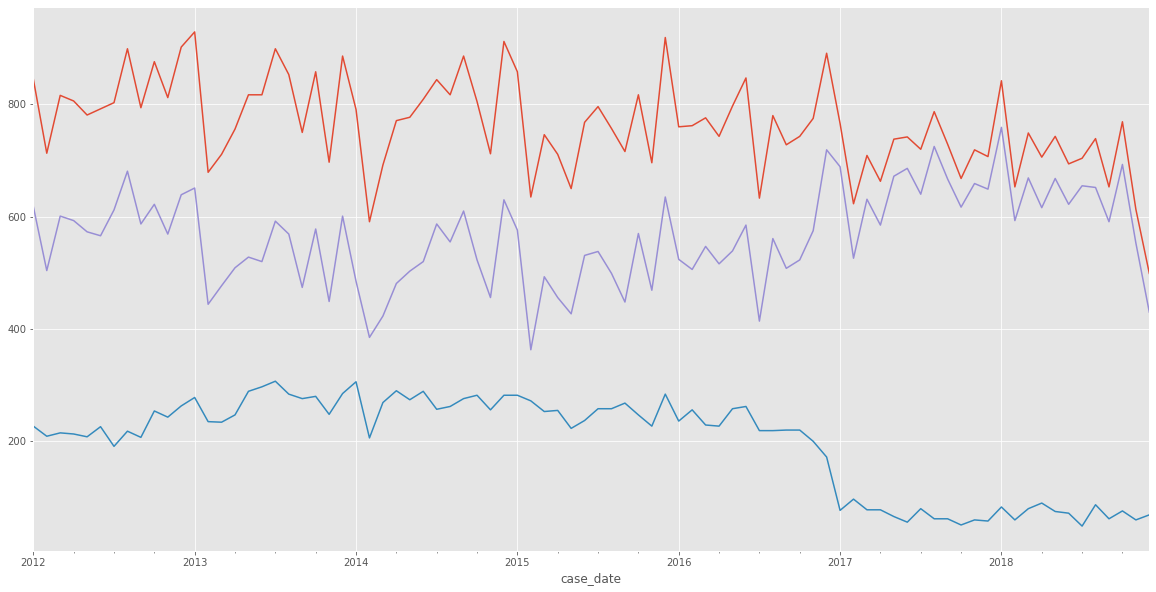

In [14]:
for charge_lvl in ['charges_fm', 'charges_f','charges_m']:
    rt.set_index('case_date')[charge_lvl].plot()

### Year Retail Theft Trends by Felony & Misdemeanor, Felony only, and Misdemeanor only

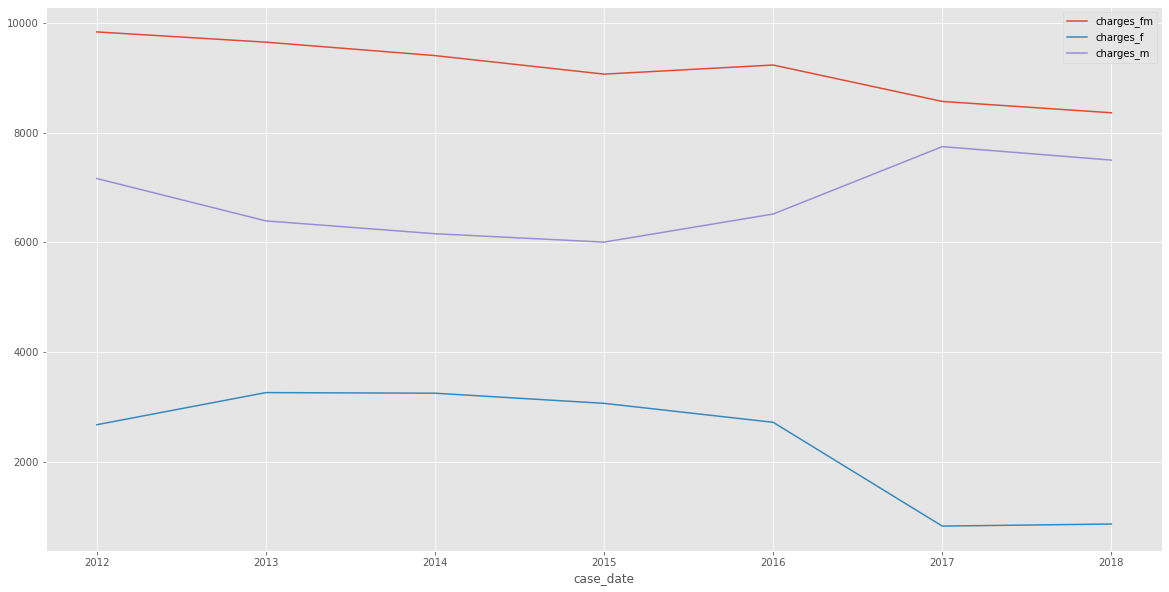

In [15]:
for charge_lvl in ['charges_fm', 'charges_f','charges_m']:  
    rt.groupby(rt['case_date'].dt.year)[charge_lvl].sum().plot(legend=True)